# Margins of error in the ACS

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mmann1123/pytidycensus/blob/main/examples/03_margins_of_error.ipynb)

Understanding and working with uncertainty in American Community Survey data.

In [1]:
import pytidycensus as tc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Census API Key

To use pytidycensus, you need a free API key from the US Census Bureau. Get one at: https://api.census.gov/data/key_signup.html


In [2]:

# tc.set_census_api_key("Your API Key Here") 

Ignore this cell. I am just loading my credentials from a yaml file in the parent directory.

In [3]:
import os

# Try to get API key from environment
api_key = os.environ.get("CENSUS_API_KEY")

# For documentation builds without a key, we'll mock the responses
try:
 tc.set_census_api_key(api_key)
 print("Using Census API key from environment")
except Exception:
 print("Using example API key for documentation")
 # This won't make real API calls during documentation builds
 tc.set_census_api_key("EXAMPLE_API_KEY_FOR_DOCS")

Census API key has been set for this session.
Using Census API key from environment


## Understanding ACS Uncertainty

Unlike decennial Census counts, ACS data are estimates with margins of error.

In [4]:
# Example: Aging populations in Ramsey County, MN
age_vars = [f"B01001_0{i:02d}" for i in range(20, 26)] + [f"B01001_0{i:02d}" for i in range(44, 50)]

ramsey = tc.get_acs(
 geography="tract",
 variables=age_vars,
 state="MN", 
 county="Ramsey",
 year=2022,
 output="wide",
)
ramsey.head()

Getting data from the 2018-2022 5-year ACS


,GEOID,B01001_020E,B01001_021E,B01001_022E,B01001_023E,B01001_024E,B01001_025E,B01001_044E,B01001_045E,B01001_046E,...,B01001_022_moe,B01001_023_moe,B01001_024_moe,B01001_025_moe,B01001_044_moe,B01001_045_moe,B01001_046_moe,B01001_047_moe,B01001_048_moe,B01001_049_moe
0,27123030100,70,57,39,111,22,34,59,89,76,...,25.0,40.0,30.0,26.0,58.0,40.0,41.0,47.0,65.0,49.0
1,27123030201,138,67,229,71,19,84,44,118,84,...,148.0,70.0,33.0,50.0,40.0,66.0,59.0,41.0,30.0,60.0
2,27123030202,11,15,38,11,0,12,18,0,0,...,23.0,17.0,9.0,21.0,19.0,9.0,9.0,9.0,9.0,9.0
3,27123030300,30,106,183,94,19,41,47,39,203,...,87.0,55.0,31.0,32.0,40.0,46.0,89.0,60.0,39.0,24.0
4,27123030400,77,119,58,7,0,11,18,0,86,...,44.0,12.0,13.0,13.0,23.0,13.0,62.0,13.0,10.0,31.0


In [5]:
# Show cases where MOE exceeds estimate
ramsey["moe_ratio"] = (
 ramsey["B01001_020_moe"] / ramsey["B01001_020E"]
) # Example MOE column
print("Cases where margin of error exceeds estimate: 'GEOID'")
print(ramsey[ramsey['moe_ratio'] > 1]['GEOID'].head())

Cases where margin of error exceeds estimate: 'GEOID'
2 27123030202
3 27123030300
4 27123030400
6 27123030601
8 27123030702
Name: GEOID, dtype: object


## Aggregating Data and MOE Calculations

When combining estimates, we need to properly calculate the margin of error.

In [6]:
# Custom MOE calculation functions (simplified versions)
def moe_sum(moes, estimates):
 """Calculate MOE for sum of estimates"""
 return np.sqrt(sum(moe**2 for moe in moes))

# Aggregate population over 65 by tract
ramsey_65plus = (
 ramsey.groupby("GEOID")
 .agg(
 {
 "B01001_020E": "sum",
 "B01001_020_moe": lambda x: moe_sum(
 x, ramsey.loc[x.index, "B01001_020E"]
 ),
 }
 )
 .rename(columns={"B01001_020_moe": "moe_sum"})
)

print("Aggregated estimates with proper MOE calculation:")
print(ramsey_65plus.head())

Aggregated estimates with proper MOE calculation:
 B01001_020E moe_sum
GEOID 
27123030100 70 57.0
27123030201 138 83.0
27123030202 11 17.0
27123030300 30 35.0
27123030400 77 84.0


## Visualization with Confidence Intervals

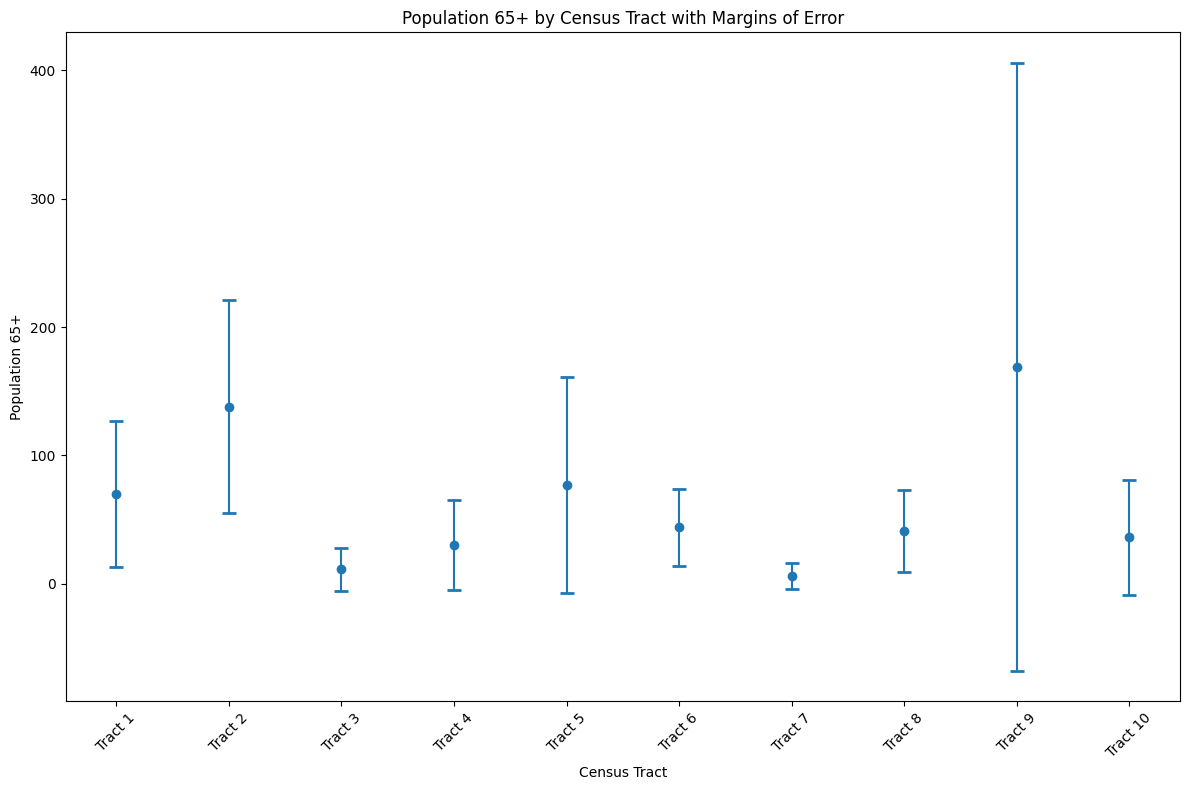

In [7]:
# Create error bar plot showing uncertainty
fig, ax = plt.subplots(figsize=(12, 8))

sample_data = ramsey_65plus.head(10)
x = range(len(sample_data))

ax.errorbar(
 x,
 sample_data["B01001_020E"],
 yerr=sample_data["moe_sum"],
 fmt="o",
 capsize=5,
 capthick=2,
)
ax.set_xlabel('Census Tract')
ax.set_ylabel('Population 65+')
ax.set_title('Population 65+ by Census Tract with Margins of Error')
plt.xticks(x, [f'Tract {i+1}' for i in x], rotation=45)
plt.tight_layout()
plt.show()